In [1]:
import pandas as pd 
import json

In [2]:
# ! mv /Users/spangher/Downloads/combined_test_prompt1_v2.json ../data/v2_queries/

In [3]:
source_df_with_clusters = pd.read_csv('cache/2024-09-19__source-df-with-all-clusters.csv', index_col=0)

In [47]:
train_set_sources = json.load(open('../data/v2_queries/combined_train_prompt1_v2.json'))
test_set_sources = json.load(open('../data/v2_queries/combined_test_prompt1_v2.json'))

In [53]:
comb_source_df = pd.concat([
    pd.DataFrame(train_set_sources).assign(split='train'),
    pd.DataFrame(test_set_sources).assign(split='test')
])

In [55]:
source_df = (
    comb_source_df
    .explode('sources')
    .pipe(lambda df: pd.concat([
        df[['url', 'query', 'split']].reset_index(drop=True),
        pd.DataFrame(df['sources'].tolist())
    ], axis=1)
 )
)

In [57]:
source_df_w_oracle_sources = (
    source_df
     # .explode('Original Name')
 .merge(
     # source_df_with_clusters.drop(columns='Name'),#.explode('Original Name'), 
     # left_on=['url', 'Original Name'], 
     # right_on=['url', 'Original Name'],
     source_df_with_clusters.drop(columns='Original Name'),#.explode('Original Name'), 
     left_on=['url', 'Name'], 
     right_on=['url', 'Name'],
     how='left'
 )
 .assign(matched=lambda df: df['Narrative Function'].notnull())
)

In [58]:
labels_to_use = source_df_with_clusters['cluster_descript_leaf_3'].str.split(':').str.get(0).value_counts()
inferred_to_human_label_mapper = {
    '"Insightful Resource"': "Expert Insights",                  
    '"Analytical Depth"': "Analysis and Criticism",    
    '"Credibility and Engagement"': "Credibility and Engagement",                     
    '"Influential Source"': "Central Figure",            
    '"Alternative Viewpoints"': "Alternative Viewpoints",    
    '"Contextual Insight"': "Background Information",    
    '"Contextual Information"': "Background Information",    
    '"Contextual Insights"': "Peripheral Context",        
    '"Key Source"': "Central Figure",
    '"Extensive Expert Analysis"': "Expert Analysis",
    '"Contextual Guidance"': "Author Perspective",        
    '"Practical Case Studies"': "Anecdotes",                 
    '"Background Insight Providers"': "Background Information",    
    '"Background Enrichment Sources"': "Examples and Illustration", 
    '"Credibility Anchor"': "Authoritative Source",     
}

In [237]:
source_df_with_oracles_mapped = (
    source_df_w_oracle_sources
         .assign(oracle_label=lambda df: 
                 df['cluster_descript_leaf_3'].str.split(':').str.get(0).map(inferred_to_human_label_mapper)
                )
            [['url', 'query', 'split', 'Name', 'Original Name', 'Information', 'oracle_label', 'matched']]
)

output_test_df_w_oracles = (
    source_df_with_oracles_mapped
         .loc[lambda df: df['split'] == 'test']
         .groupby(['url', 'query'])
         .apply(lambda df: pd.Series({
             'sources': df[['Name', 'Original Name', 'Information', 'oracle_label']].to_dict(orient='records'),
             '% match': df['matched'].mean()
         }))
)

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_59725/3069256920.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({


# Make new labels

In [506]:
source_df_with_oracles_mapped.to_csv('cache/discourse_training_data_raw.csv')
! scp cache/discourse_training_data_raw.csv mit:~/

discourse_training_data_raw.csv               100%  270MB   2.9MB/s   01:34    
scp: close remote: Failure
scp: failed to upload file cache/discourse_training_data_raw.csv to ~/


### Try training a smaller BERT classifier

In [507]:
import pandas as pd 
# source_df_with_oracles_mapped = pd.read_csv('discourse_training_data_raw.csv.gz')
distinct_labels = source_df_with_oracles_mapped['oracle_label_condensed'].dropna().unique()
# label2int_mapper = {k:i for i, k in enumerate(distinct_labels)}
# int2label_mapper = {i:k for i, k in enumerate(distinct_labels)}
label2int_mapper = {
    'Direct Participant': 0,
    'Central Figure': 0,
    'Counterpoint': 1,
    'Alternative Viewpoints': 1,
    'Background Information': 2,
    'Peripheral Context': 3,
    'Analysis': 4,
    'Expert': 5,
    'Anecdotes, Examples and Illustration': 6,
    'Author Perspective': 7
}
int2label_mapper = {v:k for k,v in label2int_mapper.items()}

train_df, test_df = (
    source_df_with_oracles_mapped
        .loc[lambda df: df['matched']]
        .assign(text=lambda df: 
                'ARTICLE TOPIC: ' + df['query'] + 
                '\nSOURCE NAME: ' + df['Name'] + 
                '\nSOURCE INFO: ' + df['Information'])
        .rename(columns={"oracle_label_condensed": "label"})
        # .assign(label=lambda df: df['label'].map(discrete_label_mapper))
        .groupby('split')
        .apply(lambda df: df[["text", "label"]])
        .pipe(lambda df: (df.loc['train'], df.loc['test']))
)

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_59725/3111145820.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df[["text", "label"]])


In [157]:
idx = 6
print(train_df.iloc[idx]['text'])
print()
print(train_df.iloc[idx]['label'])

ARTICLE TOPIC: Is Bumble's initial public offering worth the buzz, and can it compete with industry leader Match Group?
SOURCE NAME: Ali Mogharabi
SOURCE INFO: Ali Mogharabi is a Morningstar analyst who expects 2021 revenue above the guidance range due to pent-up demand and long-term changes in romance- or partner-seeking behavior.

Expert Analysis


In [ ]:
import numpy as np 
from datasets import Dataset, DatasetDict
import evaluate
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer, TrainingArguments, Trainer
import os

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=len(distinct_labels), id2label=int2label_mapper, label2id=label2int_mapper
)

def preprocess_function(examples):
    output_dict = tokenizer(examples["text"], truncation=True)
    output_dict['label'] = list(map(label2int_mapper.get, examples['label']))
    return output_dict
    

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(predictions=predictions, references=labels, average='macro')

ds = DatasetDict()
ds['train'] = Dataset.from_pandas(train_df.dropna())#.sample(50_000))
ds['test'] =  Dataset.from_pandas(test_df.dropna())#.sample(10_000))
tokenized_ds = ds.map(preprocess_function, batched=True, num_proc=10)
training_args = TrainingArguments(
    output_dir="cache/discourse-model",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

### use GPT to label all sources

In [432]:
oracle_to_condensed_oracle_mapper = {
    'Credibility and Engagement': 'Anecdotes, Examples and Illustration',
    'Authoritative Source': "Direct Participant",
    'Background Information': "Background Information",
    'Analysis and Criticism': "Analysis",
    'Central Figure': "Direct Participant",
    'Examples and Illustration': "Anecdotes, Examples and Illustration",
    'Alternative Viewpoints': 'Counterpoint',
    'Expert Analysis': 'Expert',
    'Expert Insights': 'Expert',
    'Author Perspective': 'Author Perspective',
    'Anecdotes': 'Anecdotes, Examples and Illustration',
    'Peripheral Context': 'Peripheral Context',
}

In [433]:
source_df_with_oracles_mapped= (source_df_with_oracles_mapped
 .assign(oracle_label_condensed=lambda df: df['oracle_label'].map(oracle_to_condensed_oracle_mapper))
)

In [434]:
source_df_with_oracles_mapped['oracle_label_condensed'].value_counts()

oracle_label_condensed
Expert                                  61964
Direct Participant                      47990
Anecdotes, Examples and Illustration    44920
Background Information                  43341
Analysis                                38539
Counterpoint                            22016
Peripheral Context                      12924
Author Perspective                      11173
Name: count, dtype: int64

In [444]:
(source_df_with_oracles_mapped
 .loc[lambda df: df['oracle_label_condensed'] == 'Direct Participant']
 [['query', 'Name', 'Information']]
 .iloc[15]
 .to_dict()
)

{'query': "What is the Biden administration considering doing to restrict China's access to advanced artificial intelligence technology, and how might this impact the US tech industry?",
 'Name': 'Nvidia',
 'Information': "Nvidia's shares closed down 1.8 percent on Wednesday after reports of the potential export crackdown, and the company has been one of the primary beneficiaries of the enthusiasm over artificial intelligence, with its share price surging by roughly 180 percent this year. China typically generates 20 percent to 25 percent of the company's data center revenue, which includes other products in addition to chips that enable A.I. The company began offering the downgraded A800 and H800 chips in China last year in response to the restrictions."}

In [445]:
PROMPT = """
I am trying to determine the role a source plays in this news article, based on the information it provides. 

Choose from these categories:

"Anecdotes, Examples and Illustration"
"Direct Participant"
"Background Information"
"Peripheral Context"
"Analysis"
"Counterpoint"
"Expert"
"Author Perspective"
 
Here are definitions for each category:

* "Anecdotes, Examples and Illustration": These sources offer real-world stories to build trust, influence audience understanding, and enhance reliability of information
* "Direct Participant": These sources are the main individual, company, or entity featured in news articles and are involved in decision-making.
* "Background Information": These sources provide broader context to events, helping readers understand the main topic in the context of what is going on and grasp peripheral details.
* "Peripheral Context": These sources offer content that is not main or background, but introduces new angles or directions.
* "Analysis": These sources offer insights and forecasts, often explaining what things mean going forward.
* "Counterpoint": These sources offer diverse perspectives or examples of differences, opposing opinions to provide a more balanced understanding.
* "Expert": These sources collectively provide essential data, statistics, facts to back up understanding.
* "Author Perspective": These sources offer personal voices, usually from the author of the article.

Here are some examples of sources with their labels:

ARTICLE TOPIC: "Is Bumble's initial public offering worth the buzz, and can it compete with industry leader Match Group?",
SOURCE NAME: "Match Group"
SOURCE INFO: "Match Group is a $45 billion dating conglomerate. The company is valued at $46 billion, or roughly eight times Bumble's current valuation.
LABEL: Counterpoint

ARTICLE TOPIC: 'Will the emerging space travel industry be accessible to the general public or remain a luxury only the super rich can afford?',
SOURCE NAME: 'Ceridwen Dovey',
SOURCE INFO: 'Dovey says that the space barons are shrewdly tapping into our respect for astronauts and our idealism about what space represents.'
LABEL: Analysis

ARTICLE TOPIC: "What is the Biden administration doing to restrict China's access to advanced artificial intelligence technology?"
SOURCE NAME: 'Nvidia',
SOURCE INFO: "Nvidia's shares closed down 1.8 percent on Wednesday after reports of the potential export crackdown of it's chips to China."

Now it's your turn:

ARTICLE TOPIC: {query}
SOURCE NAME: {source_name}
SOURCE INFO: {source_info}
LABEL:
"""

In [446]:
prompts = source_df_with_oracles_mapped.apply(lambda x: PROMPT.format(
    query=x['query'],
    source_name=x['Name'],
    source_info=x['Information'])
, axis=1 )

In [447]:
# mkdir ../data/label_discourse/

In [448]:
prompts_df = pd.concat([
    source_df_with_oracles_mapped[['url', 'Name']],
    prompts.str.strip().to_frame('Prompt'),
], axis=1).drop_duplicates()

In [449]:
batch_prompts = (
    prompts_df
        .drop_duplicates(['url', 'Name'])
        .apply(
            lambda x: {
                "custom_id": x['url'] + '___' + x['Name'], 
                "method": "POST", 
                "url": "/v1/chat/completions", 
                "body": {
                    "model": "gpt-4o-mini",
                    "messages": [{
                        "role": "system", 
                        "content": "You are a helpful journalist's assistant."
                    },{
                        "role": "user", "content": x['Prompt']
                    }],"max_tokens": 20
                }}
        , axis=1)
)

In [450]:
import jsonlines
to_upload = []
BATCH_SIZE = 20_000
for i, s in enumerate(tqdm(range(0, len(batch_prompts), BATCH_SIZE))):
    e = s + BATCH_SIZE
    one_batch_df = batch_prompts.iloc[s:e]
    too_long_ids = one_batch_df.str.get('custom_id').str.len().pipe(lambda s: s > 512)
    fname = f'../data/label_discourse/input_data/discourse-batch-{i}.jsonl'
    with jsonlines.open(fname, 'w') as f:
        f.write_all(one_batch_df.loc[lambda s: ~too_long_ids].tolist())
        assert one_batch_df.loc[lambda s: ~too_long_ids].str.get('custom_id').str.len().pipe(lambda s: s > 512).any() == False
    to_upload.append(fname)

  0%|          | 0/25 [00:00<?, ?it/s]

In [217]:
import tiktoken
from tqdm.auto import tqdm
enc = tiktoken.encoding_for_model("gpt-4o-mini")
# tqdm.pandas()
# prompts_df['Prompt'].progress_apply(enc.encode).str.len().sum()

In [218]:
num_tokens = 278303795
278303795 / 1_000_000 * .075
# >>> 20.872784624999998

20.872784624999998

In [451]:
import glob, re
batch_files_on_disk = sorted(glob.glob('../data/label_discourse/input_data/*'), key=lambda x: int(re.search(r'\d+', x)[0]))

In [452]:
from openai import OpenAI
import os 

os.environ['OPENAI_API_KEY'] = open('/Users/spangher/.openai-isi-project-key.txt').read().strip()
client = OpenAI()

In [453]:
batch_file_ids = []
for f in tqdm(batch_files_on_disk):
# for f in tqdm(to_upload):
    batch_input_file = client.files.create(file=open(f, "rb"), purpose="batch")
    batch_file_ids.append(batch_input_file)

  0%|          | 0/25 [00:00<?, ?it/s]

In [454]:
batch_jobs= []
for b_file in tqdm(batch_file_ids):
    batch_input_file_id = b_file.id
    batch_job = client.batches.create(
        input_file_id=batch_input_file_id,
        endpoint="/v1/chat/completions",
        completion_window="24h",
        metadata={
          "description": "nightly eval job"
        }
    )
    batch_jobs.append(batch_job)

  0%|          | 0/25 [00:00<?, ?it/s]

In [311]:
# get data

In [ ]:
batch_job_ids = list(map(lambda x: x.id, batch_jobs))
batch_statuses = list(map(client.batches.retrieve, batch_job_ids))
completed_batches = (
    pd.DataFrame(list(map(lambda x: x.to_dict(), batch_statuses)))
         .loc[lambda df: df['status'] == 'completed']
         # ['output_file_id'].tolist()
)

In [ ]:
completed_batches['input_file_name'] = completed_batches['input_file_id'].apply(client.files.retrieve).apply(lambda x: x.filename)
for _, (input_file_name, output_id) in tqdm(completed_batches[['input_file_name', 'output_file_id']].iterrows(), total=len(completed_batches)):
    file_response = client.files.content(output_id)
    name, ext = os.path.splitext(input_file_name)
    with open(f'../data/label_discourse/output_data/{name}__output{ext}', 'w') as f:
        f.write(file_response.text)

### Examine OpenAI Output

In [ ]:
import jsonlines
import numpy as np 

all_output_items = []
for f in glob.glob('../data/label_discourse/output_data/discourse-batch-*__output.jsonl'):
    output_items = list(jsonlines.open(f))
    all_output_items.extend(output_items)

In [482]:
output_df = pd.DataFrame(all_output_items)
output_df = (
    output_df[['custom_id', 'response']]
         .assign(label=lambda df: df['response'].str.get('body').str.get('choices').str.get(0).str.get('message').str.get('content') )
         .drop(columns='response')
         .assign(url=lambda df: df['custom_id'].str.split('___').str.get(0))
         .assign(Name=lambda df: df['custom_id'].str.split('___').str.get(1))
         .drop(columns='custom_id')
)

In [480]:
label_list = set([
    "Credibility and Engagement",
    "Authoritative Source",
    "Background Information",
    "Analysis and Criticism",
    "Central Figure",
    "Examples and Illustration",
    "Alternative Viewpoints",
    "Expert Analysis",
    "Expert Insights",
    "Author Perspective",
    "Anecdotes",
    "Peripheral Context",
])

label_list = set(['Analysis',
 'Anecdotes, Examples and Illustration',
 'Author Perspective',
 'Background Information',
 'Counterpoint',
 'Direct Participant',
 'Expert',
 'Peripheral Context'])

In [477]:
sorted_l = sorted(label_list, key=lambda x: -len(x))

In [481]:
def get_label(l):
    l = l.replace('\'', '').replace('"', '').replace('*', '')
    if l in label_list:
        return l
    else:
        for l_i in label_list:
            if l_i in l:
                return l_i
    return np.nan


output_df['label'] = output_df['label'].apply(get_label)

In [495]:
output_df['label'].value_counts()

label
Background Information                  133736
Direct Participant                      120317
Expert                                   75054
Peripheral Context                       46967
Anecdotes, Examples and Illustration     22590
Counterpoint                             18608
Analysis                                 15254
Author Perspective                       12481
Name: count, dtype: int64

In [498]:
old_new_df = (
    source_df_with_oracles_mapped
         [['url', 'Name', 'query', 'Information', 'oracle_label']]
         .assign(oracle_label=lambda df: df['oracle_label'].map(oracle_to_condensed_oracle_mapper))
         .merge(output_df)
         .loc[lambda df: df['oracle_label'].notnull() & df['label'].notnull() ]
)

In [499]:
old_new_df.loc[491393]

url             www.expressnews.com/news/local/article/Tyson-v...
Name                                     Green Gate Garden Center
query           What is the impact of Tyson Foods' decision to...
Information     Green Gate Garden Center in Seguin began manda...
oracle_label                                             Analysis
label                                          Direct Participant
t_label                                        Direct Participant
Name: 491393, dtype: object

In [500]:
from sklearn.metrics import f1_score, confusion_matrix

In [512]:
old_new_df.loc[491393].to_dict()

{'url': 'www.expressnews.com/news/local/article/Tyson-vaccine-mandate-Delta-variant-texas-16369371.php',
 'Name': 'Green Gate Garden Center',
 'query': "What is the impact of Tyson Foods' decision to mandate vaccines on the city of Seguin, Texas, and its residents?",
 'Information': 'Green Gate Garden Center in Seguin began mandating vaccines for all customer-facing employees, all but one of its roughly 15 store workers complied.',
 'oracle_label': 'Analysis',
 'label': 'Direct Participant',
 't_label': 'Direct Participant'}

In [513]:
old_new_df.pipe(lambda df: f1_score(df['oracle_label'], df['label'], average='macro'))

0.2736150546046034

In [514]:
old_new_df.pipe(lambda df: f1_score(df['oracle_label'], df['label'], average='micro'))

0.3124138396068089

In [515]:
c = confusion_matrix(old_new_df['oracle_label'],old_new_df['label'], labels=list(sorted(label_list)))

In [516]:
c_df = pd.DataFrame(c, index=list(sorted(label_list)), columns=list(sorted(label_list)))

<Axes: xlabel='oracle_label', ylabel='label'>

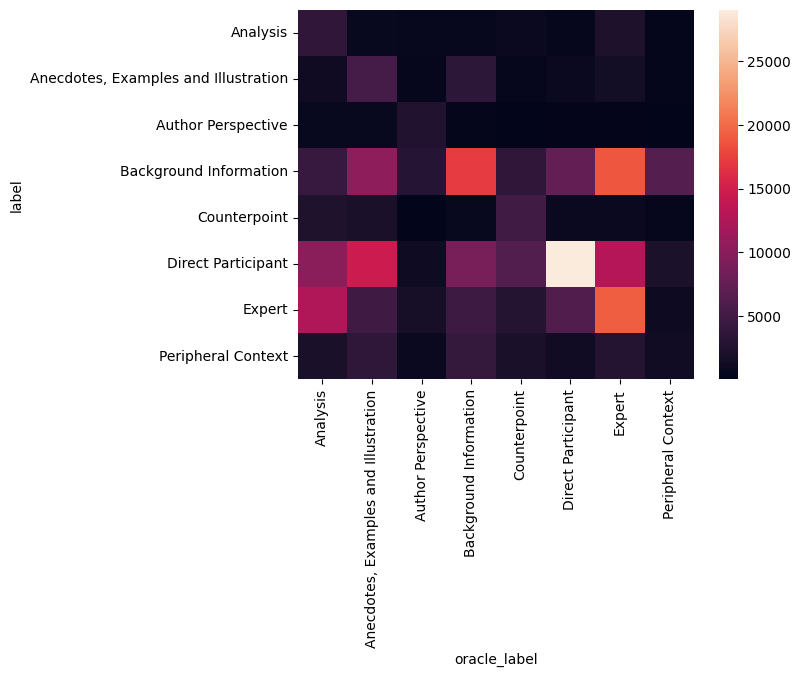

In [524]:
sns.heatmap(old_new_df.value_counts(['label', 'oracle_label']).unstack())

Text(0.5, 23.52222222222222, 'GPT4-Mini Labels')

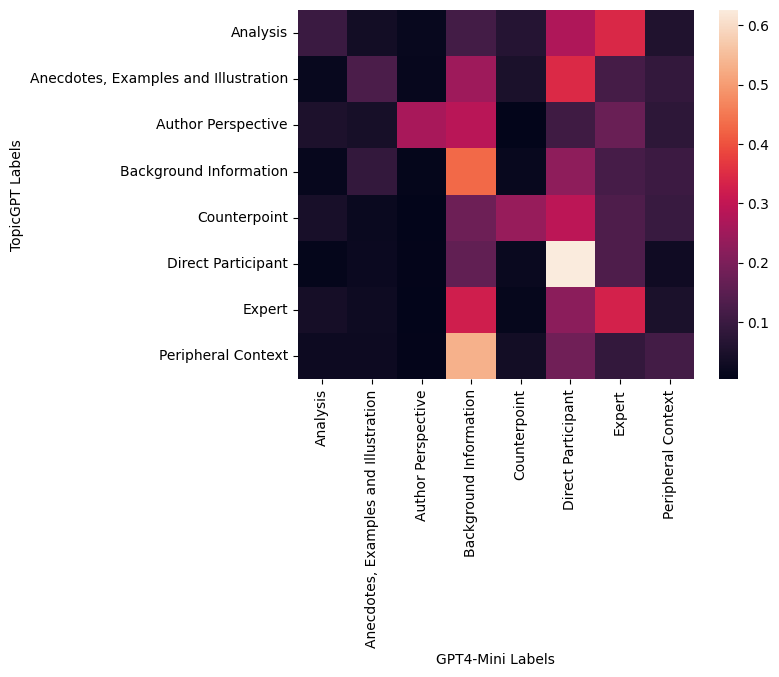

In [525]:
import seaborn as sns
import matplotlib.pyplot as plt
# g = sns.clustermap(
    # c_df.divide(c_df.sum(axis=1), axis=0),
    # figsize=(6,6,)
# )
sns.heatmap(c_df.divide(c_df.sum(axis=1), axis=0))
plt.ylabel('TopicGPT Labels')
plt.xlabel('GPT4-Mini Labels')

In [529]:
(old_new_df[['url', 'Name', 'query', 'Information', 'oracle_label', 'label']]
 .sample(1000)
 .to_csv('cache/old_new_discourse_labels_to_evaluation.csv')
)

### Do manual validation


In [315]:
i = list(jsonlines.open('../data/label_discourse/input_data/discourse-batch-0.jsonl'))

In [290]:
pd.DataFrame(all_output_items).assign(content=lambda df: df)

,id,custom_id,response,error
0,batch_req_6702399d6c6881908ba7b9250aa9aa68,nypost.com/2023/05/17/target-may-lose-500m-fro...,"{'status_code': 200, 'request_id': 'bd6ac81c82...",None
1,batch_req_6702399d92148190bab00a77676f586f,nypost.com/2023/05/17/target-may-lose-500m-fro...,"{'status_code': 200, 'request_id': 'e1a7ed51cc...",None
2,batch_req_6702399db80c8190be4a2187b8728fd4,nypost.com/2023/05/17/target-may-lose-500m-fro...,"{'status_code': 200, 'request_id': '7fdeed00d1...",None
3,batch_req_6702399dd6448190a2866e35d55a19d1,nypost.com/2023/05/17/target-may-lose-500m-fro...,"{'status_code': 200, 'request_id': '1770b9b389...",None
4,batch_req_6702399e02448190825dcc7ea1147907,nypost.com/2023/05/17/target-may-lose-500m-fro...,"{'status_code': 200, 'request_id': '14a2de0f8b...",None
...,...,...,...,...
487410,batch_req_67024b1bb208819092e5c2645823727d,www.cbsnews.com/minnesota/news/lake-street-tar...,"{'status_code': 200, 'request_id': '4db1cecee6...",None
487411,batch_req_67024b1bc5208190b58a25df332bb23e,nypost.com/2023/05/17/target-may-lose-500m-fro...,"{'status_code': 200, 'request_id': '6eb6823eb0...",None
487412,batch_req_67024b1bddc48190acee9a8e926e513b,nypost.com/2023/05/17/target-may-lose-500m-fro...,"{'status_code': 200, 'request_id': '792f14ba40...",None
487413,batch_req_67024b1c066c81909f47b1e10c113670,nypost.com/2023/05/17/target-may-lose-500m-fro...,"{'status_code': 200, 'request_id': '7f41d139f3...",None


# Format Examples

In [161]:
output_matched_test_df_w_oracles = (
    output_test_df_w_oracles
         .loc[lambda df: df['% match'] > .85]
         .reset_index()
)

In [162]:
output_matched_test_df_w_oracles['sources'].explode().str.get('oracle_label').value_counts()

sources
Expert Insights               4149
Background Information        3525
Analysis and Criticism        3155
Central Figure                2991
Credibility and Engagement    2384
Alternative Viewpoints        1930
Peripheral Context            1114
Expert Analysis               1075
Author Perspective             939
Anecdotes                      865
Examples and Illustration      716
Authoritative Source           477
Name: count, dtype: int64

In [163]:
(output_matched_test_df_w_oracles
 .drop(columns='% match')
 .to_json('../data/v2_queries/combined_test_prompt1_v2__with_oracle.json', orient='records')
)

In [142]:
# ! open ../data/v2_queries

In [142]:
(source_df_with_clusters[['cluster_descript_leaf_3']]
 .drop_duplicates()
 .assign(label=lambda df: df['cluster_descript_leaf_3'].str.split(':').str.get(0))
 .assign(human_label=lambda df: df['label'].map(inferred_to_human_label_mapper))
 .assign(cluster_descript_leaf_3=lambda df: df.apply(lambda x: x['cluster_descript_leaf_3'].replace(x['label'], '"{}"'.format(x['human_label'])), axis=1))
['human_label'].tolist()
)

['Credibility and Engagement',
 'Authoritative Source',
 'Background Information',
 'Analysis and Criticism',
 'Central Figure',
 'Examples and Illustration',
 'Central Figure',
 'Alternative Viewpoints',
 'Expert Analysis',
 'Expert Insights',
 'Author Perspective',
 'Background Information',
 'Anecdotes',
 'Peripheral Context',
 'Background Information']

In [158]:
import pyperclip
pyperclip.copy('\n\n'.join(source_df_with_clusters[['cluster_descript_leaf_3']]
 .drop_duplicates()
 .assign(label=lambda df: df['cluster_descript_leaf_3'].str.split(':').str.get(0))
 .assign(human_label=lambda df: df['label'].map(inferred_to_human_label_mapper))
 .assign(cluster_descript_leaf_3=lambda df: df.apply(lambda x: x['cluster_descript_leaf_3'].replace(x['label'], '"{}"'.format(x['human_label'])), axis=1))
 ['cluster_descript_leaf_3'].tolist()
               ))

"Credibility and Engagement": These sources contribute to building trust, influence audience understanding, and enhancing the reliability of information by providing personal accounts, insights and warnings.

"Authoritative Source": These sources provide verified, expert-backed information that enhances the trustworthiness and reliability of the content they support.

"Background Information": These sources provide broader context to events, helping readers understand the main topic in the context of what is going on and grasp peripheral details.

"Analysis and Criticism": These sources are experts and insiders. They offer deep insights, critiques, and multifaceted interpretations of complex issues and decisions across diverse fields.

"Central Figure": These sources are the main individual, company, or entity featured in news articles, serving as the focal point by providing important information, insights, actions, decisions, and statements.

"Examples and Illustration": These sources provide background information in different ways, enhancing the main content for a more comprehensive grasp of topics discussed.

"Alternative Viewpoints": These sources offer diverse perspectives, critical analyses, and opposing opinions to provide a more balanced understanding and challenge dominant views across various topics.

"Expert Analysis": These sources offer a broad and detailed range of expert analyses and insights, enriching the article's depth and credibility.

"Expert Insights": These sources collectively provide essential data, context, analysis, and credibility across diverse topics, enhancing depth and understanding in journalistic articles and ensuring comprehensive and accurate reporting.

"Author Perspective": These sources that offer analysis and personal insights, usually from the author of the article.

"Anecdotes": These sources offer diverse and specific examples that highlight different responses, adaptations, successes, challenges, innovations, and impacts across sectors, providing insights into broader themes and concepts.

"Peripheral Context": These sources enrich the main content by offering deeper context than typical background sources.

In [206]:
examples_mapped_df = (
    test_set_df_with_oracles_mapped[['url', 'Name', 'Information']]
     .merge(source_df_with_clusters
             .assign(label=lambda df: df['cluster_descript_leaf_3'].str.split(':').str.get(0))
             .assign(human_label=lambda df: df['label'].map(inferred_to_human_label_mapper))
             [['url', 'Name', 'Narrative Function', 'human_label']]
))

In [208]:
t = (examples_mapped_df
 .groupby('human_label').apply(lambda df: df.head().reset_index(drop=True))
)

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_7229/2021855737.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby('human_label').apply(lambda df: df.head().reset_index(drop=True))


In [209]:
cats = list(set(map(lambda x: x[0], t.index)))

In [210]:
cats

['Background Information',
 'Credibility and Engagement',
 'Examples and Illustration',
 'Author Perspective',
 'Expert Analysis',
 'Peripheral Context',
 'Anecdotes',
 'Alternative Viewpoints',
 'Authoritative Source',
 'Expert Insights',
 'Analysis and Criticism',
 'Central Figure']

In [227]:
len(cats)

12

In [246]:
idx = 11
cats[idx]

'Central Figure'

In [249]:
t2 = (t.loc[cats[idx]][['Name', 'Information', 'Narrative Function']]
 .rename(columns={'Name': 'Source name', 'Information': 'Info. provided', 'Narrative Function': 'Narrative function'})
 .iloc[[0, 3]].to_dict(orient='records')
)
# for t_i in t2:
    # for k,v in t_i.items():
        # print(f'{k}: {v}')
    # print()
t2

[{'Source name': 'Sam Bankman-Fried',
  'Info. provided': 'Sam Bankman-Fried is the founder of FTX and former chief executive of FTX. He was arrested in the Bahamas and appeared in court, where he was denied bail. He was taken away in handcuffs and was described as a modern-day John Pierpont Morgan, but is now likened to Bernie Madoff, the fraudster who orchestrated a notorious Ponzi scheme. He was a major donor to the Democratic Party and known for his commitment to effective altruism, a charitable movement that urges adherents to give away their wealth in efficient and logical ways.',
  'Narrative function': '"Main Actor": This source is the main actor in the news article and the subject of the story.'},
 {'Source name': 'Boeing',
  'Info. provided': 'Boeing admitted that it may never know what caused the battery malfunctions that resulted in all its 787 Dreamliner aircraft being grounded. Replacement battery systems are now being fitted to all 50 Dreamliners that had been in operati

'"Expert Insights": 
    {'Source name': 'S&P Global',
    'Info. provided': 'The value of deposites relative to a company's overall worth.',
    'Narrative function': 'In a story about a company's value, this source provides data and statistics about the situation.'},
    {'Source name': 'Irene Knapp',
    'Info. provided': 'Insights about the lack of executive leadership at a company',
    'Narrative function': 'In a story about a company's failings, this source is used to express concerns and criticisms about culture and leadership',}

"Central Figure":
    {'Source name': 'Joyann Ferguson-Pratt',
      'Info. provided': "A judge who makes a key ruling in a case being discussed in the article.",
      'Narrative function': 'In a story about a case, this source made decision that affects the main actor.'},
     {'Source name': 'Larry Loftis',
      'Info. provided': "The general manager company provides his view on where the company is going based on his leadership",
      'Narrative function': "In a story about a company, this source provides detailed information about the company\'s actions, decisions, and technology.'}

"Examples and Illustration":
    {'Source name': 'NASA',
     'Info. provided': "Information about a flight they piloted.",
      'Narrative function': 'In a story about worldwide space programs, provides context and information about US government's priorities, goals, and timelines.'}
    {'Source name': 'A local bank',
     'Info. provided': 'States that all shareholders get the same information at the same time.',
    'Narrative function': 'In a story about the effects of regulations, this source is used to provide context and background information on how a regulation is being followed.'}

'Author Perspective':
    {'Source name': 'Ross Marchand',
     'Info. provided': 'The director of policy at an organization with a general opinion, writes an article.',
      'Narrative function': 'This source is used to provide the author\'s opinion and perspective on the issue.'},
     {'Source name': 'David Ingram',
      'Info. provided': 'David Ingram is a journalist who covers tech for NBC News.',
      'Narrative function': 'The author of the article, providing context and background information.'}

'Expert Analysis':
    {'Source name': 'Martin Sankey',
      'Info. provided': 'A senior research analyst who has been following a company closely.',
      'Narrative function': In a story about a company, this source provides expert opinion from a senior research analyst.'},
     {'Source name': 'Brian Fry',
      'Info. provided': 'Provides advice on investment apps and offers insights on how to choose the best app for individual needs and goals.',
      'Narrative function': 'In a story about investment apps, this source provides expert opinions on investment apps.'}

"Peripheral Context":
    {'Source name': 'HBO',
     'Info. provided': 'Released a documentary about a company, which keeps it in the public eye and affect the job prospects of former employees.',
      'Narrative function': 'In a story about how a company's misfortunes went public, this source provides context for the unfolding events.'},
     {'Source name': 'Attorneys',
      'Info. provided': 'Presented closing arguments in a trial.',
      'Narrative function': 'In a story about a trial, this source is used to provide context about the trial and the actions of the lawyers involved.'}

'Anecdotes':
    {'Source name': 'Japan Airlines',
      'Info. provided': "Infomration about a battery overheating incident.",
      'Narrative function': "In a story about accidents, this source is used as an example of an airline that experienced a battery malfunction incident.'},
     {'Source name': 'Fidelity Go',
      'Info. provided': 'Offers an easy-to-understand investment app.',
      'Narrative function': 'In a story about investment apps, this source provides an example of one.'}

'Alternative Viewpoints':
    {'Source name': 'Airbus',
      'Info. provided': 'Airbus was planning to use lithium-ion batteries in its new plane, the A350, but has decided against it after watching Boeing struggle to prove they are safe.',
      'Narrative function': 'In a story about the decisions of a company, this source is used as a comparison.'},
    {'Source name': 'TD Ameritrade',
  'Info. provided': 'This company offers a range of investment products and services, including brokerage accounts, robo-advisors, and financial planning tools.',
  'Narrative function': 'In a story about investment apps, this source is used to provide a counterpoint to other investment apps.'}

  
'Authoritative Source':
    {'Source name': 'US aircraft regulators',
      'Info. provided': 'US aircraft regulators approved a revamped battery design for the 787.',
      'Narrative function': 'In a story about airplane batteries, this source is an authority about an issue and is involved in the events.'},
     {'Source name': 'Commodity Futures Trading Commission',
      'Info. provided': "Alleges that an actor took money that customers wanted to use.",
      'Narrative function': 'In a story about corporate malfeasance, this source has an inside look involved in the events of the story.'}

"Expert Insights":
{'Source name': 'Sundar Pichai',
'Info. provided': "The source provided insights about a technology being a tremendously positive force.",
  'Narrative function': 'In a story about AI, this source is used to provide a statement from Google\'s CEO.'},
 {'Source name': 'Google',
  'Info. provided': "Provides information about company structure.",
  'Narrative function': 'In a story about a company, this source is used to provide factual information about Google, its policies, and its actions.'}


'Analysis and Criticism':
{'Source name': 'Peter Schoomaker',
  'Info. provided': 'This source provides an insider\'s explanation for the cancellation of a program and its implications.',
  'Narrative function': 'In a story about US Army decision making, this source explains and pushes back on some information.'},
 {'Source name': 'Google employees',
  'Info. provided': "Employees who asked questions about a memo had their comments and identities leaked elsewhere online.",
  'Narrative function': 'In a story about a corporate mishap, this source provides insight into what happened and criticizes the company.'}

"Central Figure":
{'Source name': 'Sam Bankman-Fried',
  'Info. provided': 'The founder of a company.',
  'Narrative function': 'In a story about the company, this source is the main actor in the news article and the subject of the story.'},
 {'Source name': 'Boeing',
  'Info. provided': 'The company admitted that it may never know what caused the battery malfunctions.',
  'Narrative function': 'In a story about a company's malfeasance, this source is the main actor in the news article and provides information about the company\'s actions and decisions.'}


# Old Work

In [ ]:
train_queries = json.load(open('../data/v2_queries/query_train_prompt1_v2.json'))
test_queries = json.load(open('../data/v2_queries/query_test_prompt1_v2.json'))
train_query_df = pd.DataFrame(train_queries)
train_query_df['split'] = 'train'
test_query_df = pd.DataFrame(test_queries)
test_query_df['split'] = 'test'
full_query_df = pd.concat([train_query_df, test_query_df])

test_narr = json.load(open('../data/v2_narr_parsed/v2_test_set_narr.json'))
train_narr = json.load(open('../data/v2_narr_parsed/v2_train_set_narr.json'))

narr_df = pd.concat([
    pd.DataFrame(train_narr),
    pd.DataFrame(test_narr)
])
source_narr_df = narr_df.explode('sources').dropna().reset_index(drop=True)
source_narr_df = pd.concat([
    source_narr_df[['url']],
    source_narr_df['sources'].pipe(lambda s: pd.DataFrame(s.tolist()))
], axis=1)

source_narr_df.iloc[0].to_dict()

In [9]:
(
    source_df_with_clusters
         .loc[lambda df: df['cluster_descript_leaf_1'] == df['cluster_descript_leaf_1'].unique()[1]]
         .drop_duplicates('Narrative Function').iloc[0].to_dict()
)

{'url': 'www.theatlantic.com/sponsored/qualcomm-2016/the-space-within/768/',
 'Name': 'Researchers',
 'Original Name': 'researchers',
 'Narrative Function': '"Authority": This source is used to provide information about the Framingham Heart Study and its findings.',
 'cluster_descript_leaf_1': '"Expert Endorsement": These sources are used to provide authoritative and credible information, data, and guidance on various aspects of the COVID-19 pandemic, including vaccines, testing, public health guidelines, and pandemic control measures.',
 'cluster_descript_leaf_2': '"Authoritative Source": These sources provide credible, expert-backed information and validations that lend legitimacy and reliability across various topics, enhancing the trust and accuracy of the articles they support.',
 'cluster_descript_leaf_3': '"Credibility Anchor": These sources provide verified, expert-backed information that enhances the trustworthiness and reliability of the content they support.',
 'cluster_desc

In [7]:
source_df_with_clusters['cluster_descript_leaf_4'].value_counts()#$.head(2)

cluster_descript_leaf_4
"Core Narrative Sources": These sources provide key insights, credibility, context, and diverse perspectives crucial for developing, substantiating, and advancing the main narrative of the article.                                                                                           148915
"Extensive Context"\n\n"These sources provide in-depth background, integral details, and thorough narrative foundations that enhance the understanding of various topics and events, ensuring comprehensive insight."                                                                            70762
"Insightful Narratives": These sources offer detailed, informative, and contextual explanations with comprehensive data and innovative solutions, enhancing reader understanding and decision-making across various subjects.                                                                    55396
"Nuanced Discourse": These sources offer comparative analysis, opposing viewpoints, and cri

In [124]:
# source_narr_df[['url', 'Name', 'Perspective', 'Centrality']].merge(source_df_with_clusters, on=['url', 'Name'])

In [9]:
source_df_with_clusters_and_queries = source_df_with_clusters.merge(full_query_df)

In [15]:
source_df_with_clusters_and_queries.iloc[0]

url                        blog.cleveland.com/metro/2011/01/light_snow_ca...
Name                                                                  Police
Original Name                                                 Police, police
Narrative Function                                            Primary Source
cluster_descript_leaf_1                                       Primary Source
cluster_descript_leaf_2                                       Primary Source
cluster_descript_leaf_3                             Primary Narrative Source
cluster_descript_leaf_4                               Core Narrative Sources
cluster_descript_leaf_5                                  Credible Narratives
query                      What is the impact of a light snowfall on traf...
split                                                                   test
Name: 0, dtype: object

In [10]:
to_process = ['Narrative Function', 'cluster_descript_leaf_1', 'cluster_descript_leaf_2', 'cluster_descript_leaf_3', 'cluster_descript_leaf_4', 'cluster_descript_leaf_5']
source_df_with_clusters_and_queries[to_process] = (
    source_df_with_clusters_and_queries
     [to_process]
     .apply(lambda s: s.str.split(':').str.get(0).str.split('\n\n').str.get(0).str.strip().str.replace('"', ''))
)

In [11]:
broad_clusters_categories = (
    source_df_with_clusters_and_queries
         .groupby('url')['cluster_descript_leaf_5']
         .value_counts()
         .unstack()
)

In [ ]:
## classification problem:

## input: initial query — initial summary of the story 
## predict: multilabel output of the different source-categories


## process —
##    start with your query
##    planner tells you what KINDS of sources you need
##    execute query 1
##       you determine that you filled "Central Figure" category of source
##       your planner tells you you still need an "Enriched Narratives" category of source
##    this helps you formulate/execute a better followup/interleaving query
## -> can we make an HMM or Graph neural network to predict this?

## directly sample from the distribution of discourse labels?
##    slightly more advanced - use kmeans clustering to cluster 5-6 clusters of different story types and then try to assign 
##    stories to each cluster

In [192]:
train_query_df.iloc[0].to_dict()

{'url': 'www.vice.com/en/article/jg8743/facebook-spending-dollar50m-rese-to-not-ruin-metaverse-like-it-ruined-the-real-world',
 'query': 'Can a company like Facebook, with a history of contributing to real-world problems, be trusted to responsibly develop a virtual world like the metaverse?',
 'split': 'train'}

In [190]:
broad_clusters_categories.sort_values('Enriched Narratives', ascending=False)

cluster_descript_leaf_5,Central Figure,Contextual Narratives,Credible Narratives,Critical Analysis,Enriched Narratives,User Interaction
url,,,,,,
www.fox23.com/news/trending/teacher-appreciation-week-2021-deals-freebies-educators/SOQPCHBO3JAC3MXNVHGY3IFYHM/,NaN,NaN,2.0,NaN,24.0,NaN
www.chron.com/life/pets/article/New-website-guesses-what-dog-breed-you-are-6842859.php,NaN,NaN,NaN,NaN,24.0,NaN
www.usatoday.com/story/travel/flights/todayinthesky/2017/09/11/irma-snarling-flights-five-major-airline-hubs-all-once/653483001/,NaN,NaN,1.0,NaN,22.0,NaN
www.theguardian.com/technology/2014/feb/12/10-things-to-know-about-lifelogging,NaN,NaN,2.0,NaN,21.0,NaN
www.cbsnews.com/miami/news/a-guide-to-veterans-day-2020-deals-and-freebies/,NaN,NaN,1.0,NaN,21.0,NaN
...,...,...,...,...,...,...
wwwrm1.ansa.it/pressrelease/canale_salute_benessere/index.shtml,NaN,NaN,1.0,NaN,NaN,NaN
y108.cbslocal.com/2014/07/23/luke-bryan-to-honor-u-s-troops-with-free-tickets-to-chicago-concert/,1.0,NaN,1.0,NaN,NaN,NaN
youpix.virgula.uol.com.br/app/os-114-aplicativos-mais-uteis-pra-voce-baixar-agora/,1.0,1.0,11.0,1.0,NaN,NaN


In [175]:
training_data = (
    broad_clusters_categories
        .fillna(0)
        .pipe(lambda df: (df > 0).astype(float))
        .merge(full_query_df, right_on='url', left_index=True, how='left')
)
#.pipe(lambda df: df.divide(df.sum(axis=1), axis=0))#.sort_values('Contextual Narratives', ascending=False))

# Train BERT Classifier

In [182]:
training_data.to_csv('../narrative_function/bert_training_data.csv')